In [10]:
# magic
%matplotlib inline

# imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG, display # svg images
import graphviz as gv
import random as rand
from math import *
import re
import shapely
from shapely.geometry import *
from shapely.affinity import *

# my libraries
from MCR import *

# make figures large enough
from pylab import rcParams
rcParams['figure.figsize'] = (10, 10)

In [2]:
# Create a new instance of the Minimum Cover Removal problem
square = random_mcr(obstacles=14)

In [84]:
# Create an empty square
square = MCR()

In [85]:
square

In [86]:
# Add a couple of shapes to the square
shape1 = Polygon([(0.2,0.2), (0.2, 0.7), (0.7,0.7), (0.7,0.2)])
shape2 = Polygon([(0.5,0.15), (1.0,0.15), (.75, .87)])

square.add_obstacle(shape1)
square.add_obstacle(shape2)

In [87]:
# Add a start and goal
square.start = (0.05, 0.05)
square.goal  = (0.95, 0.95)

In [88]:
square.obstacles

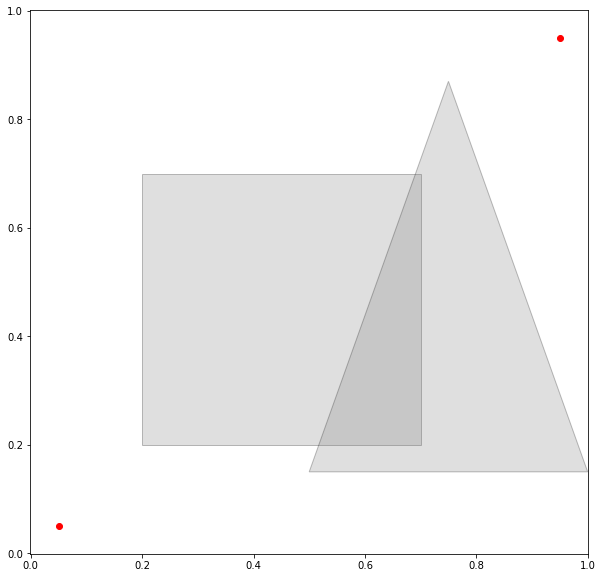

In [89]:
# Display the MCR
square.show_obstacles()

In [9]:
# And solve it.
solve_mcr(square)

# This returns a path???
# How do we display the solution overlaid on the pmp?

In [205]:
class MCR:

    '''
    Minimum Cover Removal. Contains a number of helper methods for investigating
    the MCR problem as described in Erickson and LaValle 2013 and Hauser 2012
    '''

    display_opts = {'alpha': 0.25, 'edgecolor': 'black', 'facecolor': 'gray'}

    def __init__(self, svg=None):
        '''
        Create an empty square to add shapes to.
        '''
        self.obstacles = []
        self.graph = []
        self.start = (0.05, 0.05)
        self.goal = (0.95, 0.95)
        # self.field = plt.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])

        if svg:
            # initialize from svg file
            try:
                obstacles = MCR.__shapes_from_SVG__(svg)
                for o in obstacles:
                    print(o)
                    self.add_obstacle(o)
            except:
                pass

    def add_obstacle(self, shape):
        self.obstacles.append(shape)

        # TODO: clip translated shape to field bounds
        #   - is this necessary?
        # TODO: add shape and overlaps to graph as well
        #   - or should this be done in two separate steps?

    def remove_obstacle(self, label):
        '''
        Removes the obstacle labeled 'label'.
        Removes the labeled vertices from the graph and contracts those edges
        '''
        # TODO: everything

        # Displaying the MCR
        pass

    def show_obstacles(self):
        '''
        Outputs the square
        '''
        # add start and goal
        plt.scatter(*zip(self.start, self.goal), color='red')

        # add obstacles
        for obstacle in self.obstacles:
            poly = plt.Polygon(obstacle.exterior.coords, **self.display_opts)
            plt.gca().add_patch(poly)

#         plt.axis()  # set to [0,1]
        plt.show()

    def show_graph(self):
        '''
        Outputs the square
        '''
        gv.Source(self.graph)

    def svg(self):
        '''
        Draws an SVG
        '''
        # TODO: I believe all I'll need is to change the output method of
        # matplotlib, then redraw.
        # Do I need an output file?
        pass

    # Helper methods

    def __shapes_from_SVG__(svg_file):
        try:
            f = open(svg_file)
            svg = f.read()
            f.close()
        except FileNotFoundError:
            print('File {} not found'.format(svg_file))
            return

        # Now start parsing

        shapes = []
        scaled_shapes = []

        #  Viewbox - this will be scaled to 1, 1 eventually
        try:
            viewbox = [float(x)
                       for x in re.findall('viewBox="(.*?)"', svg)[0].split()]
            vb_w = viewbox[2] - viewbox[0]
            vb_h = viewbox[3] - viewbox[1]
        except:
            print('Can\'t find a viewbox!')
            return

        # Rectangles
        rects = re.findall('<rect.*?\/>', svg)
        for r in rects:
            x_ = re.findall('x="([\d.]+)"', r)
            x = float(x_[0]) if x_ else 0.0

            y_ = re.findall('y="([\d.]+)"', r)
            y = float(y_[0]) if y_ else 0.0

            h_ = re.findall('height="([\d.]+)"', r)
            h = float(h_[0])

            w_ = re.findall('width="([\d.]+)"', r)
            w = float(w_[0])

            rect = Polygon([(x, y), (x + w, y), (x + w, y + h), (x, y + h)])
            
            # Transforms
            transform = re.search('transform="(.*?)"', r)
            if transform:
                t_list = re.split(',\w*', transform)
                for t in t_list:
                    if t.startswith('matrix'):
                        vals = re.findall('matrix\w*\((.*?)\)', t)[0]
                        rect = affine_transform(
                            rect, *[float(x) for x in re.split(',\w*', vals)]
                        )
                    elif t.startswith('translate'):
                        vals = re.findall('translate\w*\((.*?)\)', t)[0]
                        rect = translate(
                            rect, *[float(x) for x in re.split(',\w*', vals)]
                        )
                    elif t.startswith('scale'):
                        vals = re.findall('scale\w*\((.*?)\)', t)[0]
                        rect = scale(
                            rect,
                            *[float(x) for x in re.split(',\w*', vals)],
                            origin=(0, 0)
                        )
                    elif t.startswith('rotate'):
                        val = re.findall('scale\w*\((.*?)\)', t)[0]
                        rect = rotate(
                            rect, float(val), origin=(0, 0), use_radians=True
                        )
                    elif t.startswith('skewX'):
                        val = re.findall('scale\w*\((.*?)\)', t)[0]
                        rect = skew(
                            rect,
                            xs=float(vals),
                            use_radians=True
                        )
                    elif t.startswith('skewY'):
                        val = re.findall('scale\w*\((.*?)\)', t)[0]
                        rect = skew(
                            rect,
                            ys=float(vals),
                            use_radians=True
                        )

            shapes.append(rect)

        # Polygons
        polygons = re.findall('<polygon.*?\/>', svg)
        for p in polygons:
            polygon = []
            point_list = re.findall('points="(.*?)"', p)
            points = ([float(x) for x in point_list[0].split()])

            points.reverse()  # so that I can pop from the front...
            while points:
                polygon.append((points.pop(), points.pop()))
            polygon.pop()  # remove the doubled last point

            shapes.append(Polygon(polygon))

        # N.b.: the svg viewbox starts at the top left
        # rescale to [1,1]
        
        for shape in shapes:
            shape = translate(scale(
                shape,
                xfact=1 / vb_w,
                yfact=-1 / vb_h,
                origin=(0,0)
            ), 0, 1)
            scaled_shapes.append(shape)

        return scaled_shapes

In [116]:
MCR

__main__.MCR

In [117]:
# We can import an SVG
svg_square = MCR(svg='path/to/missing.svg')

# Note that this automatically scales the SVG to 0,0,1,1; clips it; and adds every shape as an obstacle
# Does it keep the colors? No, should it?

File path/to/file.svg not found


In [118]:
straws = MCR(svg='straws.svg')

POLYGON ((0 1, 0.07128904793856707 1, 0.07128904793856707 0, 0 0, 0 1))
POLYGON ((0.1031884490171227 1, 0.1744774969556898 1, 0.1744774969556898 0, 0.1031884490171227 0, 0.1031884490171227 1))
POLYGON ((0.2063818683366883 1, 0.2776709162752554 1, 0.2776709162752554 0, 0.2063818683366883 0, 0.2063818683366883 1))
POLYGON ((0.309570317353811 1, 0.380859365292378 1, 0.380859365292378 0, 0.309570317353811 0, 0.309570317353811 1))
POLYGON ((0.4127637366733766 1, 0.4840527846119437 1, 0.4840527846119437 0, 0.4127637366733766 0, 0.4127637366733766 1))
POLYGON ((0.5159521856904993 1, 0.5872412336290663 1, 0.5872412336290663 0, 0.5159521856904993 0, 0.5159521856904993 1))
POLYGON ((0.6191406347076219 1, 0.690429682646189 1, 0.690429682646189 0, 0.6191406347076219 0, 0.6191406347076219 1))
POLYGON ((0.7223340540271876 1, 0.7936231019657546 1, 0.7936231019657546 0, 0.7223340540271876 0, 0.7223340540271876 1))
POLYGON ((0.8255225030443103 1, 0.8968115509828772 1, 0.8968115509828772 0, 0.8255225030

In [119]:
straws.obstacles

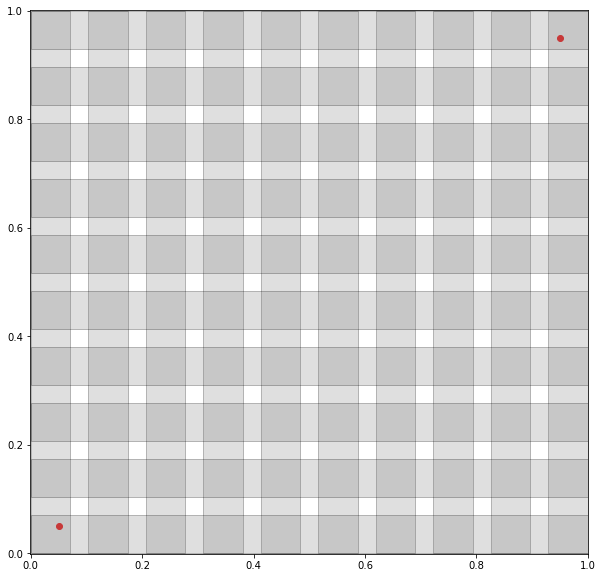

In [120]:
straws.show_obstacles()

In [15]:
# For any of these we can create a (labeled) graph
g = svg_square.graph
# This also labels the points, including the region where the start and goal are

In [16]:
svg_square

In [17]:
svg_square.start

(0.05, 0.05)

In [ ]:
# Once we have the graph, we can do all sorts of graph operations on it.
DSP(g, s, t)

In [ ]:
#  And specialized graph operations on just this kind of multilabeled graph
pmp.remove_obstacle(10)

# This removes the 2-D obstacle, and in the graph, the '10' label, e.g., from any vertex, then merges neighboring vertices
# with the same label. Can be done in \sum deg(label), if we keep an edge list

In [19]:
dot = '''
strict graph {
  a -- b
  a -- c
  b -- c [color=blue]
}
'''

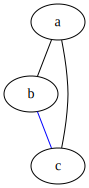

In [20]:
gv.Source(dot)

In [21]:
a = Polygon([(0, 0), (1, 1), (1, 0)])

In [22]:
b = Polygon([(0.5, 0.4), (0.7, 2), (1, 0)])

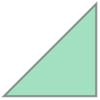

In [23]:
a

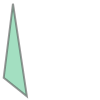

In [24]:
b

In [25]:
a.representative_point

<bound method BaseGeometry.representative_point of <shapely.geometry.polygon.Polygon object at 0x10e5d5a58>>

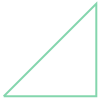

In [26]:
a.boundary

In [303]:
def random_mcr(obstacles=10, scale_factor=0.25):
    '''
    Creates an MCR with random polygonal obstacles
    '''
    mcr = MCR()
    pts = poisson_2d(obstacles)
    new_obs = []
    
    for _ in range(obstacles):
        r = scale(random_shape(), scale_factor, scale_factor)
        x, y = pts.pop()
        minx, miny, _, _ = r.bounds 
        new_obs.append(translate(r, x - minx, y - miny))
    
    # rescale again, to fit all shapes in the
    bounds = [o.bounds for o in new_obs]
    max_x = max([b[2] for b in bounds])
    max_y = max([b[3] for b in bounds])
    
    for obstacle in new_obs:
        mcr.add_obstacle(scale(obstacle, 1 / max_x, 1 / max_y, origin=(0,0)))
        
    return mcr

In [298]:
random_mcr()

AttributeError: 'zip' object has no attribute 'next'

In [272]:
def random_shape(max_sides=6):
    '''
    Creates a random convex polygon with vertices between [0,1] x [0,1].
    '''
    shape = approx_ngon(rand.randrange(3, max_sides + 1))

    # rotate it randomly
    return rotate(shape, rand.uniform(0, 2*pi), use_radians=True, origin='centroid')

In [302]:
def poisson_2d(k):
    '''
    Returns an array of k (x, y) tuples evenly spaced across [0, 1] x [0, 1]
    Note that there are tweaks to the distribution that make it unreliable
    as an _actual_ Poisson distribution.
    '''
    xs = [0]
    ys = [0]

    for _ in range(k-1):
        xs.append((xs[-1] + rand.expovariate(k+1)))
        ys.append((ys[-1] + rand.expovariate(k+1)))
    
    max_x = max(xs)
    max_y = max(ys)
                               
    xs = [x / max_x for x in xs]
    ys = [y / max_y for y in ys]
                  
    rand.shuffle(ys)
    return list(zip(xs, ys))

[(0.0, 0.4364463132146355), (0.07035454289080938, 0.6686567593136074), (0.07297793306337981, 0.5002010071345271), (0.07310092861151568, 0.6794718335072245), (0.0790643585455852, 0.08817939092030636), (0.11312409630376194, 0.16420039007675502), (0.12245862149779402, 0.7699945933775734), (0.1366009591618565, 0.4949988854192641), (0.1934461727727937, 0.3454858835219359), (0.20063119785377814, 0.49526630999893917), (0.2356053293857513, 0.4097067246815688), (0.24498555160379965, 0.25772471036778577), (0.2464003853060459, 0.3030601513306736), (0.27955743340280687, 0.944850132394408), (0.3063251866641685, 0.4317307182743089), (0.3155797836999341, 0.21352140146779341), (0.35766394468935714, 0.6265884865268867), (0.37490544366004097, 0.3902637358523628), (0.38911589531309837, 0.9275662272362047), (0.3967968452881317, 0.6646860103342682), (0.3990979480615717, 0.3491322625479873), (0.4082910611263203, 0.7524064746270478), (0.41155008388515313, 0.14240107994154189), (0.4126654653941263, 0.0), (0.4

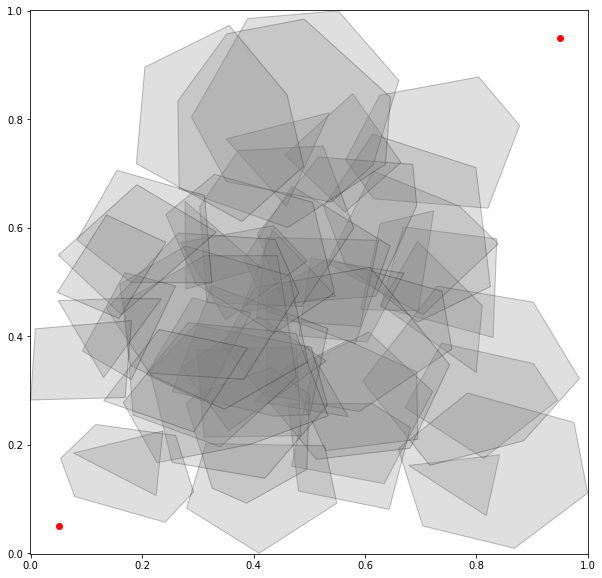

In [308]:
f = random_mcr(50)
f.show_obstacles()

In [301]:
list(f.obstacles)

In [306]:
s = MCR(svg='shapes.svg')

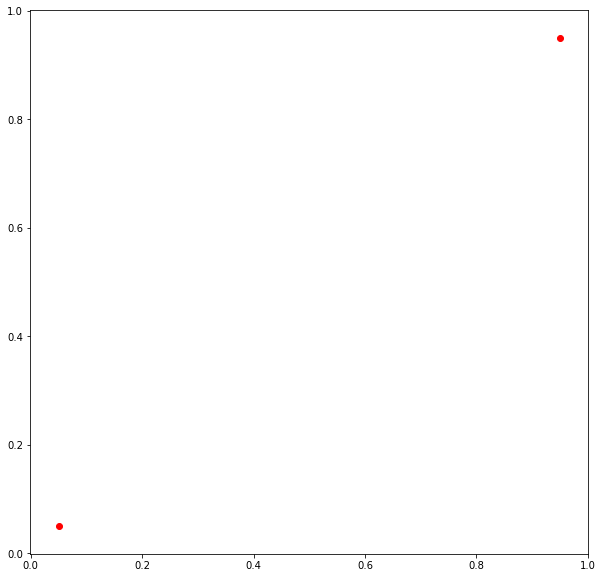

In [307]:
s.show_obstacles()